In [98]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from keras.metrics import MeanRelativeError
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape
from keras.losses import MeanSquaredError
from keras.optimizers import Adam

In [99]:
DATA_PATH = 'data_cars/'
all_files = os.listdir(DATA_PATH)

In [100]:
all_dataframes = []
number_of_files = 100
number_of_sensors = None

for index, file in enumerate(all_files):
    if index == number_of_files:
        break
    print(f"Reading file: {file}")
    file_name = file.split('.')[0]
    df = pd.read_csv(DATA_PATH + file, sep=';')

    df['date'] = pd.to_datetime(df[file_name], format='%Y-%m-%d %H:%M')
    df = df.drop(columns=[file_name])

    df = df.set_index('date')
    df.columns = [f"{file_name}_{col}" for col in df.columns if col != 'date']
    if number_of_sensors:
        all_dataframes.append(df[df.columns[:number_of_sensors]])
        # all_dataframes.append(df[df.columns[4:number_of_sensors+4]])
    else:
        all_dataframes.append(df)
    print(f"Finished reading file: {file}, shape = {df.shape}")

combined_df = pd.concat(all_dataframes, axis=1)
combined_df.fillna(method='ffill', inplace=True)
combined_df['hour'] = combined_df.index.hour
combined_df['day_of_week'] = combined_df.index.dayofweek

data = np.array(combined_df, dtype=float)
scaler = StandardScaler()
#Don't transform the time labels -> this way the scaler also works inversely on prediction data because shapes are different otherwise
data = np.append(scaler.fit_transform(data[:, :-2]), data[:, -2:], axis=1)

Reading file: K711.csv
Finished reading file: K711.csv, shape = (2880, 31)
Reading file: K701.csv
Finished reading file: K701.csv, shape = (2880, 7)
Reading file: K703.csv
Finished reading file: K703.csv, shape = (2880, 10)
Reading file: K702.csv
Finished reading file: K702.csv, shape = (2880, 8)
Reading file: K406.csv
Finished reading file: K406.csv, shape = (2880, 8)
Reading file: K405.csv
Finished reading file: K405.csv, shape = (2880, 19)
Reading file: K159.csv
Finished reading file: K159.csv, shape = (2880, 11)
Reading file: K140.csv
Finished reading file: K140.csv, shape = (2880, 5)
Reading file: K134.csv
Finished reading file: K134.csv, shape = (2880, 7)
Reading file: K120.csv
Finished reading file: K120.csv, shape = (2880, 7)
Reading file: K709.csv
Finished reading file: K709.csv, shape = (2880, 17)


In [101]:

# Calculate the maximum and mean for each column
column_max = combined_df.max()
column_mean = combined_df.mean()

# Calculate the maximum and mean for all columns

column_max = combined_df.max()
mean_of_max_values = column_max.mean()

overall_mean = combined_df.values.mean()

print("Maximum values for each column:")
print(column_max)
print("\nMean values for each column:")
print(column_mean)

print("\nOverall maximum value:")
print(mean_of_max_values)
print("\nOverall mean value:")
print(overall_mean)

Maximum values for each column:
K711_02_1       88.0
K711_02_2       70.0
K711_05_1      194.0
K711_05_2      220.0
K711_05_3       81.0
               ...  
K709_66_1       60.0
K709_71_1      201.0
K709_71_2      244.0
hour            23.0
day_of_week      6.0
Length: 132, dtype: float64

Mean values for each column:
K711_02_1      14.209375
K711_02_2      11.435764
K711_05_1      72.159722
K711_05_2      65.895833
K711_05_3      26.441319
                 ...    
K709_66_1       5.015625
K709_71_1      75.068056
K709_71_2      66.050000
hour           11.500000
day_of_week     3.100000
Length: 132, dtype: float64

Overall maximum value:
134.62878787878788

Overall mean value:
37.309806397306396


In [102]:
data.shape

(2880, 132)

In [103]:
def split_sequence(seq, look_back, look_forward):
    # Declare X and y as empty list
    X, y = [], []
    # scalers = [StandardScaler() for _ in range(seq.shape[1] - 2)]  # excluding last 2 columns

    # # Apply scalers
    # for i in range(seq.shape[1] - 2):  # excluding last 2 columns
    #     seq[:, i] = scalers[i].fit_transform(seq[:, i].reshape(-1, 1)).flatten()

    for i in range(len(seq)):
        # get the last index
        lastIndex = i + look_back

        # if lastIndex is greater than length of sequence then break
        if lastIndex + look_forward > len(seq):
            break

        # Create input and output sequence
        # Last 2 columns are time of day and day of week
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex+look_forward-1, :-2]

        # append seq_X, seq_y in X and y list
        X.append(seq_X)
        y.append(seq_y)

    # Convert X and y into numpy array
    X, y = np.array(X), np.array(y)

    return X, y

In [104]:
# def split_data(data, train_size, val_size, shuffle, look_back, steps_in_future):
#     num_of_steps = data.shape[0]

#     x, y = split_sequence(data, look_back, steps_in_future)

#     if shuffle:
#         idx = np.random.permutation(len(x))
#         x, y = x[idx], y[idx]

#     num_test = int(num_of_steps * (1 - train_size - val_size))
#     num_val = int(num_of_steps * val_size)

#     print(f"Number of test samples: {num_test}")
#     print(f"Number of validation samples: {num_val}")

#     x_train, y_train = x[:num_of_steps - num_test - num_val], y[:num_of_steps - num_test - num_val]
#     x_val, y_val = x[num_of_steps - num_test - num_val: num_of_steps - num_test], y[num_of_steps - num_test - num_val: num_of_steps - num_test]
#     x_test, y_test = x[num_of_steps - num_test:], y[num_of_steps - num_test:]

#     return x_train, y_train, x_val, y_val, x_test, y_test
def split_data(data, train_size, val_size, shuffle, look_back, steps_in_future):
    num_of_steps = data.shape[0]

    x, y = split_sequence(data, look_back, steps_in_future)

    if shuffle:
        idx = np.random.permutation(len(x))
        x, y = x[idx], y[idx]

    num_test = int(num_of_steps * (1 - train_size - val_size))
    num_val = int(num_of_steps * val_size)

    print(f"Number of test samples: {num_test}")
    print(f"Number of validation samples: {num_val}")

    x_train, y_train = x[:num_of_steps - num_test - num_val - steps_in_future], y[:num_of_steps - num_test - num_val - steps_in_future]
    x_val, y_val = x[num_of_steps - num_test - num_val - steps_in_future: num_of_steps - num_test - steps_in_future], y[num_of_steps - num_test - num_val - steps_in_future: num_of_steps - num_test - steps_in_future]
    x_test, y_test = x[num_of_steps - num_test - steps_in_future:], y[num_of_steps - num_test - steps_in_future:]

    return x_train, y_train, x_val, y_val, x_test, y_test


In [110]:
def smape(predicted, actual):

    numerator = np.abs(predicted - actual)
    denominator = (np.abs(predicted) + np.abs(actual)) / 2

    mask = actual != 0  # Creating a mask to exclude cases where actual value is 0
    smape_values = np.zeros_like(numerator)  # Initialize an array of zeros with the same shape as numerator
    smape_values[mask] = numerator[mask] / denominator[mask]  # Calculate SMAPE where actual is not 0

    return smape_values

def mape(predicted, actual):
    mask = actual != 0  # Creating a mask to exclude cases where actual value is 0
    mape_values = np.zeros_like(predicted)  # Initialize an array of zeros with the same shape as predicted
    mape_values[mask] = np.abs((actual[mask] - predicted[mask]) / actual[mask])  # Calculate MAPE where actual is not 0

    return mape_values

def smape_with_zero(predicted, actual):

    numerator = np.abs(predicted - actual)
    denominator = (np.abs(predicted) + np.abs(actual)) / 2

    mask = actual != 0  # Creating a mask to exclude cases where actual value is 0
    return numerator / denominator

# def smape(predicted, actual):
#     mask = actual > 20  # Create a mask to identify non-zero values in the actual array
#     numerator = np.abs(predicted - actual)
#     denominator = (np.abs(predicted) + np.abs(actual)) / 2

#     # Filter the arrays based on the mask and NaN values
#     numerator_filtered = numerator[~np.isnan(numerator) & mask]
#     denominator_filtered = denominator[~np.isnan(denominator) & mask]

#     return (numerator_filtered / denominator_filtered) * 100

In [106]:
data.shape[1]

132

In [115]:
def run_model(
    x_train, y_train, x_val, y_val, x_test, y_test, epochs=100, batch_size=32
):
    # Add params to do optimizing at the top
    print(x_train.shape)
    input_dim = x_train.shape[2]
    units = 128
    output_size = y_train.shape[1]
    look_back = 75

    input = keras.Input((look_back, input_dim))
    # return sequences is necessary for sequential LSTM layers
    lstm1 = LSTM(units, return_sequences=True)(input)
    lstm2 = LSTM(units)(lstm1)
    out = Dense(output_size)(lstm2)
    model = keras.models.Model(inputs=input, outputs=out)
    model.summary()

    model.compile(
        loss=MeanSquaredError(),
        optimizer=Adam(learning_rate=0.001),
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        # makes the training stop early if it notices no improvements on the validation set 10 times in a row, to prevent overfitting
        callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    )

    # make predictions
    trainPredict = model.predict(x_train)
    testPredict = model.predict(x_test)
    print(f"trainPredict shape: {trainPredict.shape}, input shape: {x_train.shape}")
    print(f"testPredict shape: {testPredict.shape}, input shape: {x_test.shape}")

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform(y_train)
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform(y_test)

    # calculate root mean squared error
    trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))

    print(f"Train Score: {trainScore:.2f} RMSE")
    testScore = np.sqrt(mean_squared_error(testY, testPredict))
    print(f"Test Score: {testScore:.2f} RMSE")

    train_smape = np.mean(smape(trainPredict, trainY)) * 100
    test_smape = np.mean(smape(testPredict, testY)) * 100

    print(f"Train SMAPE: {np.mean(train_smape):.2f}")
    print(f"Test SMAPE: {np.mean(test_smape):.2f}")

    
    train_smape_with_zero = np.mean(smape_with_zero(trainPredict, trainY)) * 100
    test_smape_with_zero = np.mean(smape_with_zero(testPredict, testY)) * 100

    print(f"Train SMAPE with zero: {np.mean(train_smape_with_zero):.2f}")
    print(f"Test SMAPE with zero: {np.mean(test_smape_with_zero):.2f}")

    train_mape = np.mean(mape(trainPredict, trainY)) * 100
    test_mape = np.mean(mape(testPredict, testY)) * 100

    print(f"Train MAPE: {np.mean(train_mape):.2f}")
    print(f"Test MAPE: {np.mean(test_mape):.2f}")
    return (
        trainPredict,
        testPredict,
        trainScore,
        testScore,
        trainY,
        testY,
        train_smape,
        test_smape,
        train_smape_with_zero,
        test_smape_with_zero,
        train_mape,
        test_mape,
    )

In [112]:

# Check if 'results' directory exists
if not os.path.exists('results'):
    os.makedirs('results')


In [119]:
results_df = pd.DataFrame()

train_scores = []
test_scores = []
runs = 20
# steps_in_future = [(i*8+1) for i in range(6, 10)]
steps_in_future = [1, 41]
# steps_in_future = [1,2,3,4] + [(i*4+1) for i in range(1, 11)]
current_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')


for i in steps_in_future:
    print(f'Running for {i} steps in future')
    results_df[f'train_score_{i}'] = np.nan
    results_df[f'test_score_{i}'] = np.nan
    results_df[f'train_relative_error_{i}'] = np.nan
    results_df[f'test_relative_error_{i}'] = np.nan

    x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, train_size=22/30, val_size=5/30, shuffle=False, look_back=75, steps_in_future=i)

    for j in range(runs):
        trainPredict, testPredict, train_scores, test_scores, trainY, testY, train_smape, test_smape, train_smape_with_zero, test_smape_with_zero, train_mape, test_mape = run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=500)
        results_df.loc[j, f'train_score_{i}'] = train_scores
        results_df.loc[j, f'test_score_{i}'] = test_scores
        results_df.loc[j, f'train_relative_error_{i}'] = np.mean(train_smape)
        results_df.loc[j, f'test_relative_error_{i}'] = np.mean(test_smape)
        results_df.loc[j, f'train_relative_error_with_zero_{i}'] = np.mean(train_smape_with_zero)
        results_df.loc[j, f'test_relative_error_with_zero_{i}'] = np.mean(test_smape_with_zero)
        results_df.loc[j, f'train_mape_{i}'] = np.mean(train_mape)
        results_df.loc[j, f'test_mape_{i}'] = np.mean(test_mape)

        
        # results_df.loc[j, f'train_relative_error_{i}'] = train_relative_error
        # results_df.loc[j, f'test_relative_error_{i}'] = test_relative_error
    results_df.to_csv(f'results/results_{current_time}.csv', index=False)
    # train_scores.append(res[2])
    # test_scores.append(res[3])

# results_df[f"train"] = train_scores
# results_df[f"test"] = test_scores
    


Running for 1 steps in future
Number of test samples: 288
Number of validation samples: 480
(2111, 75, 132)
Model: "model_163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_164 (InputLayer)      [(None, 75, 132)]         0         
                                                                 
 lstm_326 (LSTM)             (None, 75, 128)           133632    
                                                                 
 lstm_327 (LSTM)             (None, 128)               131584    
                                                                 
 dense_163 (Dense)           (None, 130)               16770     
                                                                 
Total params: 281,986
Trainable params: 281,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
66/66 [==============================] - 49s 532ms/step - loss:

In [ ]:
single_results_df = pd.DataFrame()


hour_minutes = [data.shape[1]-2, data.shape[1]-1]
hour_minutes
data[:,hour_minutes]
for i in range(data.shape[1]):
    data_used = data[:,[i]+hour_minutes]

    x_train, y_train, x_val, y_val, x_test, y_test = split_data(data_used, train_size=22/30, val_size=5/30, shuffle=False, look_back=75, steps_in_future=1)
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)
    trainPredict, testPredict, train_scores, test_scores, trainY, testY, train_smape, test_smape = run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=500)
    # Now add the test predictions to the data
    single_results_df[f'prediction_{i}'] = testPredict.flatten()

    # x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, train_size=22/30, val_size=3/30, shuffle=False, look_back=75, steps_in_future=1)

In [116]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data(data, train_size=22/30, val_size=3/30, shuffle=False, look_back=75, steps_in_future=1)


Number of test samples: 480
Number of validation samples: 288


In [118]:
trainPredict, testPredict, train_scores, test_scores, trainY, testY, train_smape, test_smape, train_smape_with_zero, test_smape_with_zero, train_mape, test_mape = run_model(x_train, y_train, x_val, y_val, x_test, y_test, epochs=500)


(2111, 75, 132)
Model: "model_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_163 (InputLayer)      [(None, 75, 132)]         0         
                                                                 
 lstm_324 (LSTM)             (None, 75, 128)           133632    
                                                                 
 lstm_325 (LSTM)             (None, 128)               131584    
                                                                 
 dense_162 (Dense)           (None, 130)               16770     
                                                                 
Total params: 281,986
Trainable params: 281,986
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
66/66 [==============================] - 47s 519ms/step - loss: 0.3365 - root_mean_squared_error: 0.5801 - val_loss: 0.1569 - val_root_mean_squared_error: 

array([[ 23.157265  ,  18.193913  ,  97.969505  , ...,   8.389905  ,
        148.72197   , 173.59805   ],
       [ 20.650839  ,  16.51537   ,  85.147766  , ...,   5.90656   ,
        140.61426   , 157.63797   ],
       [ 17.155893  ,  14.575709  ,  77.24801   , ...,   4.775408  ,
        131.57584   , 137.81433   ],
       ...,
       [  8.172374  ,   5.784875  ,  39.05243   , ...,   1.5747912 ,
         52.718212  ,  20.568352  ],
       [  8.244932  ,   6.145192  ,  39.932602  , ...,   1.7771173 ,
         54.01303   ,  25.174725  ],
       [  6.390473  ,   5.272884  ,  27.743645  , ...,   0.77588034,
         45.43375   ,  17.327236  ]], dtype=float32)

In [76]:
rmse_single = mean_squared_error(testY, testPredict)

In [78]:
np.mean(rmse_single)

63.789703970607896

In [56]:
smape_train_all = smape(testPredict, testY)

In [68]:
smape_train_single = smape(testPredict, testY)

In [57]:
smape_train_all.mean()

0.28672297404355385

In [ ]:
# smape_values = smape(testPredict, testY).mean(axis=1) * 100
# convert datetime64 to pandas datetime
end_time = pd.to_datetime(np.datetime64('2019-11-30 23:45'))

# calculate start time based on the number of timesteps and interval
start_time = end_time - pd.Timedelta(minutes=15 * (406 - 1))

# create a date range
date_range = pd.date_range(start=start_time, end=end_time, freq='15min')

# create a DataFrame
df = pd.DataFrame(smape_values, index=date_range)

# resample the data to hourly and calculate mean
hourly_means = df.resample('H').mean()

# create average of each hour over all days
avg_hourly = hourly_means.groupby(hourly_means.index.hour).mean()

# create the final table
final_table = pd.DataFrame([np.round(avg_hourly.values.mean(axis=1), 1)], index=['Average'])

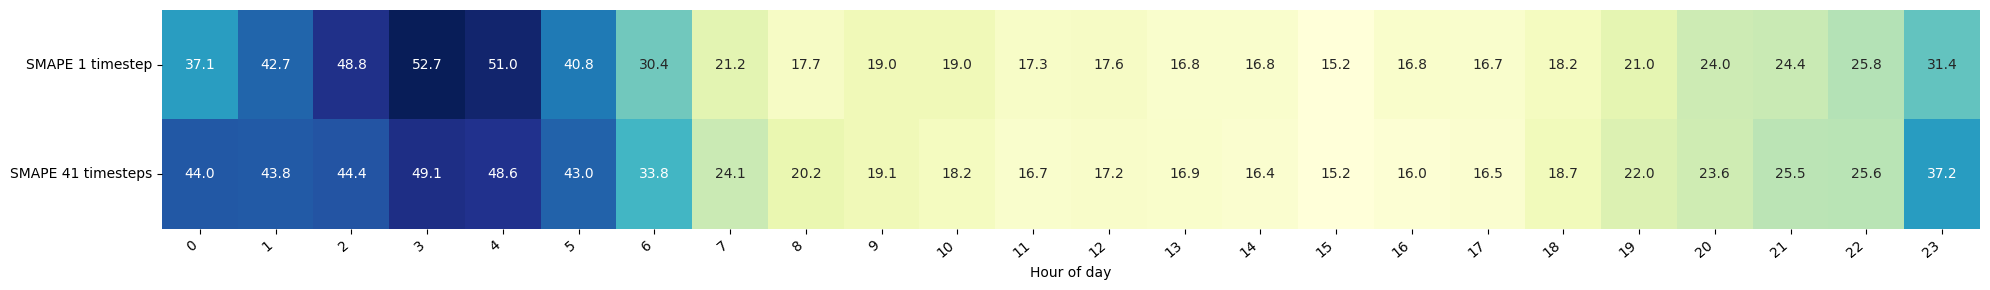

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

end_time = pd.to_datetime(np.datetime64('2019-11-30 23:45'))
start_time = end_time - pd.Timedelta(minutes=15 * (406 - 1))
date_range = pd.date_range(start=start_time, end=end_time, freq='15min')

# Combine smape_single_values and smape_all_values into a single table
combined_values = pd.DataFrame({
    'SMAPE 1 timestep': smape_single_values,
    'SMAPE 41 timesteps': smape_all_values
}, index=date_range)

# Calculate average hourly values
hourly_means = combined_values.resample('H').mean()

# Calculate average across all hours
avg_hourly = hourly_means.groupby(hourly_means.index.hour).mean()

# Create the heatmap
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(avg_hourly.T, annot=True, fmt=".1f", cmap="YlGnBu", ax=ax, cbar=False)
# ax.set_title('Combined SMAPE Values')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Hour of day')

plt.tight_layout()
plt.show()


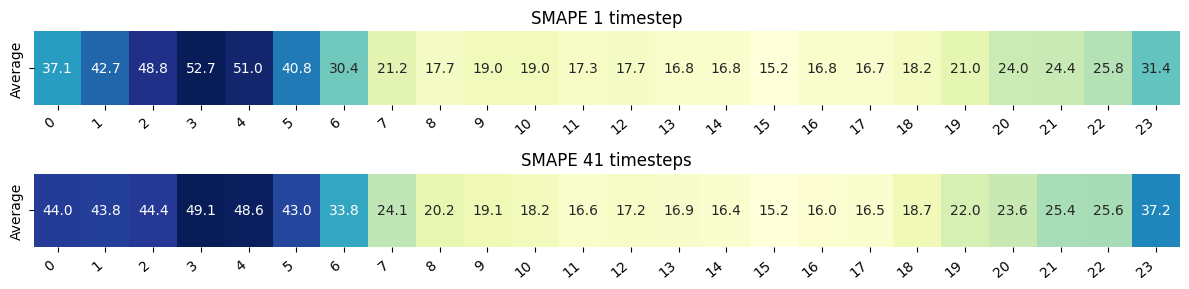

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

end_time = pd.to_datetime(np.datetime64('2019-11-30 23:45'))
start_time = end_time - pd.Timedelta(minutes=15 * (406 - 1))
date_range = pd.date_range(start=start_time, end=end_time, freq='15min')

# Create a function to prepare data and draw heatmap
def prepare_and_draw_heatmap(smape_values, ax, title):
    df = pd.DataFrame(smape_values, index=date_range)
    hourly_means = df.resample('H').mean()
    avg_hourly = hourly_means.groupby(hourly_means.index.hour).mean()
    final_table = pd.DataFrame([np.round(avg_hourly.values.mean(axis=1), 1)], index=['Average'])
    
    df_sns = pd.DataFrame(final_table.T)
    df_sns.columns = ['Average']
    sns.heatmap(df_sns.T, annot=True, fmt=".1f", cmap="YlGnBu", ax=ax, cbar=False)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

# Create a new figure and two subplots (axes)
fig, axs = plt.subplots(2, 1, figsize=(12, 3))

# Draw heatmaps for smape_single_values and smape_all_values
prepare_and_draw_heatmap(np.round(smape_single_values, 1), axs[0], 'SMAPE 1 timestep')
prepare_and_draw_heatmap(np.round(smape_all_values, 1), axs[1], 'SMAPE 41 timesteps')

plt.tight_layout()
plt.show()


In [45]:
smape_single_values.mean()

26.649562147401742

In [46]:
smape_all_values.mean()

27.252739572665

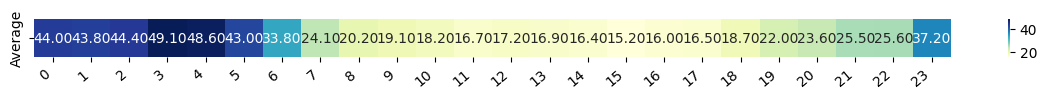

In [37]:
import seaborn as sns

# Create a DataFrame for seaborn
df_sns = pd.DataFrame(final_table.T)
df_sns.columns = ['Average']
# df_sns['Hour'] = df_sns['Hour'].astype(int)

# Draw the heatmap
plt.figure(figsize=(12, 1))
ax = sns.heatmap(df_sns.T, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Now let's plot the table
fig, ax = plt.subplots(1, 1)

table_data = [
    ["Hour", "Average"],
    *zip(final_table.columns, final_table.values[0])
]

table = ax.table(cellText=table_data, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Hide axes
ax.axis('off')

plt.show()


In [ ]:

# Assuming testPredict and testY are NumPy arrays of shape (365, 130)
mean_testPredict = np.mean(testPredict, axis=1)
mean_testY = np.mean(testY, axis=1)

# Plot the training predictions
plt.figure(figsize=(20, 10))
# plt.plot(testPredict, label='Predicted')
# plt.plot(testY, label='Actual')
plt.plot(mean_testPredict, label='Mean Predicted', linewidth=2)
plt.plot(mean_testY, label='Mean Actual', linewidth=2)
plt.legend()
plt.show()

In [ ]:
import matplotlib.dates as mdates

mean_testPredict = np.mean(testPredict, axis=1)
mean_testY = np.mean(testY, axis=1)

# Define the time range for x-axis
last_timestamp = np.datetime64('2019-11-30 23:45')
time_step_minutes = 15
num_timesteps = mean_testPredict.shape[0]
start_timestamp = last_timestamp - np.timedelta64(time_step_minutes * num_timesteps, 'm')

# Generate the x-axis values
time_range = np.arange(start_timestamp, last_timestamp, np.timedelta64(time_step_minutes, 'm'))

# Plot the training predictions
plt.figure(figsize=(20, 10))
plt.plot(time_range, mean_testPredict, label='Predicted value', linewidth=2)
plt.plot(time_range, mean_testY, label='Actual value', linewidth=2)
# plt.plot(time_range, testPredict[:,4], label='5th value', linewidth=2)
# plt.plot(time_range, testY[:,4], label='5th value', linewidth=2)
plt.plot(time_range, smape_train.mean(axis=1), label='SMAPE', linewidth=2)

plt.legend()
plt.xlabel('Timestamp')
plt.ylabel('Amount of vehicles/15 minutes')
# plt.title('LSTM Results')

# Format x-axis tick labels
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))  # Specify the interval between major ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))  # Set the date format
plt.xticks(fontsize=14) 

# Add a sparse grid
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [ ]:

# Calculate mean predictions and actual values
mean_testPredict = np.mean(testPredict, axis=1)
mean_testY = np.mean(testY, axis=1)

# Calculate SMAPE values
smape_values = smape_train.mean(axis=1) * 100

# Define the time range for x-axis
last_timestamp = np.datetime64('2019-11-30 23:45')
time_step_minutes = 15
num_timesteps = mean_testPredict.shape[0]
start_timestamp = last_timestamp - np.timedelta64(time_step_minutes * num_timesteps, 'm')

# Generate the x-axis values
time_range = np.arange(start_timestamp, last_timestamp, np.timedelta64(time_step_minutes, 'm'))

# Plot the training predictions and actual values
fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Amount of vehicles/15 minutes', color=color)
ax1.plot(time_range, mean_testPredict, label='Predicted value', color='b', linewidth=2)
ax1.plot(time_range, mean_testY, label='Actual value', color='g', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Create a twin y-axis for SMAPE
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('SMAPE %', color=color)
ax2.plot(time_range, smape_values, label='SMAPE', color='r', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Format x-axis tick labels
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(fontsize=14)

# Add a sparse grid
ax1.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [ ]:
for r in testY:
    print(np.round(r))

In [ ]:
# Plot the training predictions
plt.figure(figsize=(20,10))
plt.plot(testPredict[:, 1], label='Predicted')
plt.plot(testY[:, 1], label='Actual')
plt.legend()
plt.show()

In [ ]:
# Plot the numpy smape_train
plt.figure(figsize=(20,10))

plt.plot(smape_train)
plt.title('SMAPE train')
plt.ylabel('SMAPE')
plt.xlabel('Time')
plt.legend(['SMAPE train'], loc='upper left')
plt.show()

In [ ]:
# Separate train and test mean scores
mean_train_scores = [mean_scores[f'train_score_{t+1}'] for t in range(steps_in_future)]
mean_test_scores = [mean_scores[f'test_score_{t+1}'] for t in range(steps_in_future)]

# Calculate time step * 15 minutes
time_steps = [t * 15 for t in range(1, steps_in_future +1)]

# Create a new figure
plt.figure()

# Plot mean train scores
plt.plot(time_steps, mean_train_scores, label='Train')

# Plot mean test scores
plt.plot(time_steps, mean_test_scores, label='Test')

# Add labels and legend
plt.title("Mean RMSE scores for each step in future")
plt.xlabel('Time (minutes)')
plt.ylabel('RMSE Score')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your code for plotting the training predictions
plt.figure(figsize=(20, 10))
plt.plot(testPredict, label='Predicted')
plt.plot(testY, label='Actual')
plt.legend(loc='upper left')

# Create the second y-axis for the SMAPE train plot
ax2 = plt.gca().twinx()

# Reverse the smape_train array
reversed_smape_train = smape_train

# Your code for plotting the reversed smape_train
ax2.plot(reversed_smape_train, color='green')
ax2.set_ylabel('SMAPE %')
ax2.invert_yaxis()
ax2.legend(['SMAPE'], loc='upper right')

# Set labels and title for the combined plot
plt.xlabel('Time')
plt.title('Predicted vs Actual with SMAPE')

plt.show()

In [ ]:
results_df.mean()

In [ ]:
results

In [ ]:
results_df = pd.DataFrame.from_dict(results)

In [ ]:
results_df.mean()

In [ ]:
train_df = pd.DataFrame(trainPredict, columns=['train_predict'])
train_df['train_actual'] = trainY

In [ ]:
# Make a graph of this
train_df[:100].plot()